In [1]:
from utils import load_meters_data, prepare_data
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import random

In [2]:
time_steps = 24
df = load_meters_data(esave_path="data/EsaveExport_Trondheim Kommune_Trondheim_10121314.xls")
X_train, X_test = prepare_data(df, time_steps=time_steps, split_ratio=0.2)

In [3]:
channels = X_train.shape[2]
X = X_train
print(X.shape, X[0])

(35060, 24, 368) [[0.03200091 0.03200091 0.02858444 ... 0.12082906 0.16865961 0.14360551]
 [0.03086209 0.03086209 0.02858444 ... 0.10944084 0.18574194 0.13221729]
 [0.03200091 0.03200091 0.02858444 ... 0.12082906 0.18232548 0.12082906]
 ...
 [0.02516798 0.0263068  0.0263068  ... 0.13221729 0.11399613 0.08666439]
 [0.02516798 0.0263068  0.02858444 ... 0.12082906 0.1174126  0.15499374]
 [0.02972327 0.0263068  0.03086209 ... 0.16638196 0.13449493 0.12082906]]


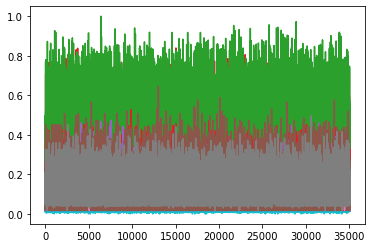

In [4]:
plt.plot(X[:,0])
plt.show()

In [5]:
latent_dim = 10

# create autoencoder with layers [(channels, time_steps), (channels,), (latent_dim,), (channels,), (channels, time_steps)]
model = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=(time_steps, channels)),
        keras.layers.Dense(50, activation="relu"),
        keras.layers.Dense(latent_dim, activation="relu"),
        keras.layers.Dense(50, activation="relu"),
        keras.layers.Dense(time_steps * channels, activation="relu"),
        keras.layers.Reshape((time_steps, channels))
    ]
)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 8832)              0         
                                                                 
 dense (Dense)               (None, 50)                441650    
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
 dense_2 (Dense)             (None, 50)                550       
                                                                 
 dense_3 (Dense)             (None, 8832)              450432    
                                                                 
 reshape (Reshape)           (None, 24, 368)           0         
                                                                 
Total params: 893,142
Trainable params: 893,142
Non-trai

Epoch 1/10
247/247 [==============================] - 2s 7ms/step - loss: 2.8300e-04 - val_loss: 2.7918e-04
Epoch 2/10
247/247 [==============================] - 2s 6ms/step - loss: 2.7700e-04 - val_loss: 2.7332e-04
Epoch 3/10
247/247 [==============================] - 2s 6ms/step - loss: 2.7349e-04 - val_loss: 2.7107e-04
Epoch 4/10
247/247 [==============================] - 2s 6ms/step - loss: 2.7012e-04 - val_loss: 2.6720e-04
Epoch 5/10
247/247 [==============================] - 2s 6ms/step - loss: 2.6818e-04 - val_loss: 2.6646e-04
Epoch 6/10
247/247 [==============================] - 2s 6ms/step - loss: 2.6262e-04 - val_loss: 2.5878e-04
Epoch 7/10
247/247 [==============================] - 2s 6ms/step - loss: 2.5932e-04 - val_loss: 2.5794e-04
Epoch 8/10
247/247 [==============================] - 2s 6ms/step - loss: 2.5772e-04 - val_loss: 2.5532e-04
Epoch 9/10
247/247 [==============================] - 2s 6ms/step - loss: 2.5508e-04 - val_loss: 2.5175e-04
Epoch 10/10
247/247 [=======

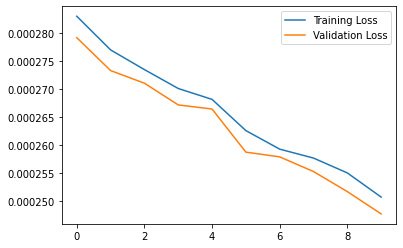

In [11]:
history = model.fit(
    X,
    X,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    shuffle=True,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min")
    ],
)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [7]:
out = model.predict(X[0].reshape((1,time_steps,channels)))
print(X[0].reshape((1,time_steps,channels)).shape, out.shape)

(1, 24, 368) (1, 24, 368)


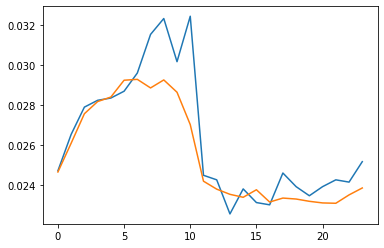

In [15]:
X_pred = model.predict(X)
plt.plot(X[2,:,0])
plt.plot(X_pred[2,:,0])
plt.show()

In [16]:
class Anomaly:
    def __init__(self, name, start, end):
        self.name = name
        self.start = start
        self.end = end
        
    # same anomaly if they had the difference in interval is max 1 day from start and end
    def __eq__(self, other):
        if not isinstance(other, Anomaly):
            return False
        return self.name == other.name and abs(self.start - other.start) <= 24*7*2 and abs(self.end - other.end) <= 24*7*2
    
    def update(self, other):
        if self.end <= other.end:
            self.end = other.end
        
        if self.start >= other.end:
            self.start = other.start
        
    def __repr__(self):
        return f"({self.name}, start={self.start}, end={self.end})"
    
    def __iter__(self):
        return iter((self.name, self.start, self.end))

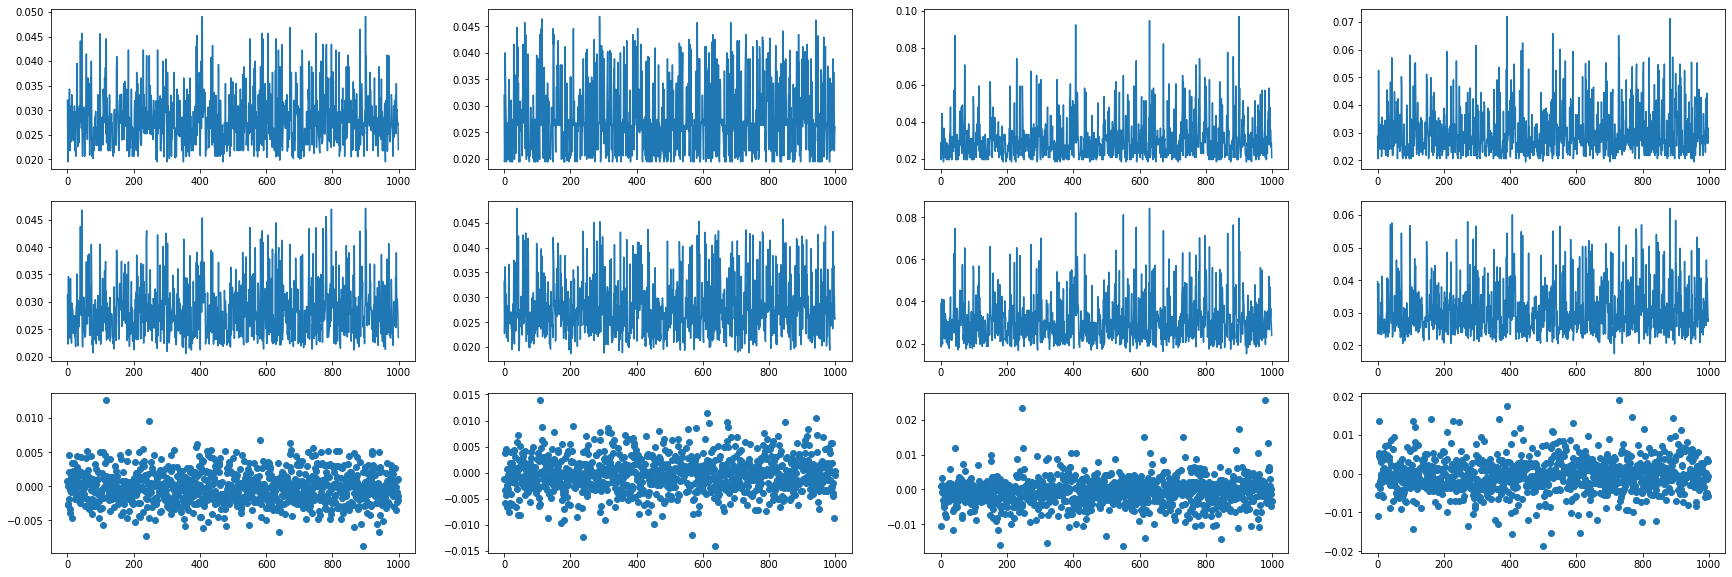

In [19]:
n = 4
plt.figure(figsize=(30, 10))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.plot(X[:1000,0,i])
    ax = plt.subplot(3, n, i + 1 + n)
    plt.plot(X_pred[:1000,0,i])
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    res = X[:1000,0,i] - X_pred[:1000,0,i]
    plt.scatter(range(len(res)), res)
    
plt.show()

In [21]:
anomalies = []

mae_loss = np.mean(np.abs(X_pred - X), axis=1)
print(mae_loss.shape, X_pred.shape)
for t, mae in enumerate(mae_loss):
    channel = np.where(mae > 0.2)
    if np.any(channel):
        #print(channel[0], mae)
        anomalies.append([t, channel[0][0]])
        #print(t, channel, mae[channel[0]])
        
anomalies = np.stack(anomalies)
print(anomalies.shape)
# print(anomalies)

def create_intervals(anomaly_points):
    # anomaly points must be: #anomalies x [idx, channel]
    intervals = {} # key = channel. value = [[start, end], [start, end]...]
    discontinuity = 48
    anomaly_points = anomaly_points.copy()
    for channel in set(anomalies[:,1]):
        channel_points = anomaly_points[np.where(channel == anomaly_points[:,1])][:,0]
        
        channel_points.sort()
        channel_points = list(channel_points)
        channel_intervals = []
        #print(channel_points)
        
        start = channel_points.pop(0)
        prev = start
        while channel_points:
            current = channel_points.pop(0)
            if current - prev > discontinuity:
                if start != prev:
                    channel_intervals.append([start, prev])
                start = current
            prev = current
        
        if channel_intervals:
            intervals[str(channel)] = channel_intervals
    return intervals
        
anomaly_intervals = create_intervals(anomalies)
print(anomaly_intervals)

(35060, 368) (35060, 24, 368)
(413, 2)
{'362': [[2183, 2204], [3022, 3042], [4734, 4751], [6623, 6647], [6812, 6847], [8843, 8851], [10897, 10941], [11044, 11084], [11294, 11297], [12219, 12231], [13008, 13026], [13474, 13485], [14675, 14720], [15008, 15064], [15174, 15208], [19145, 19150], [19862, 19885], [20478, 20525], [21149, 21173], [21323, 21331], [21609, 21722], [21824, 21829], [22507, 22541], [23597, 23645], [23702, 23714], [24207, 24264], [25769, 25815], [28380, 28393], [28553, 28566], [28714, 28723], [30064, 30109], [30187, 30191], [30866, 30933], [32482, 32511], [33510, 33527], [33914, 33927]], '331': [[1953, 1979], [21274, 21312], [22439, 22461], [23387, 23412], [24076, 24093]], '333': [[1639, 1655], [2961, 2987], [3169, 3212], [4039, 4050], [8202, 8217], [15483, 15516], [19865, 19905], [20971, 20978], [22240, 22343], [22632, 22676], [31786, 31828], [32119, 32146], [32211, 32215], [34110, 34129]], '153': [[19749, 19781]]}


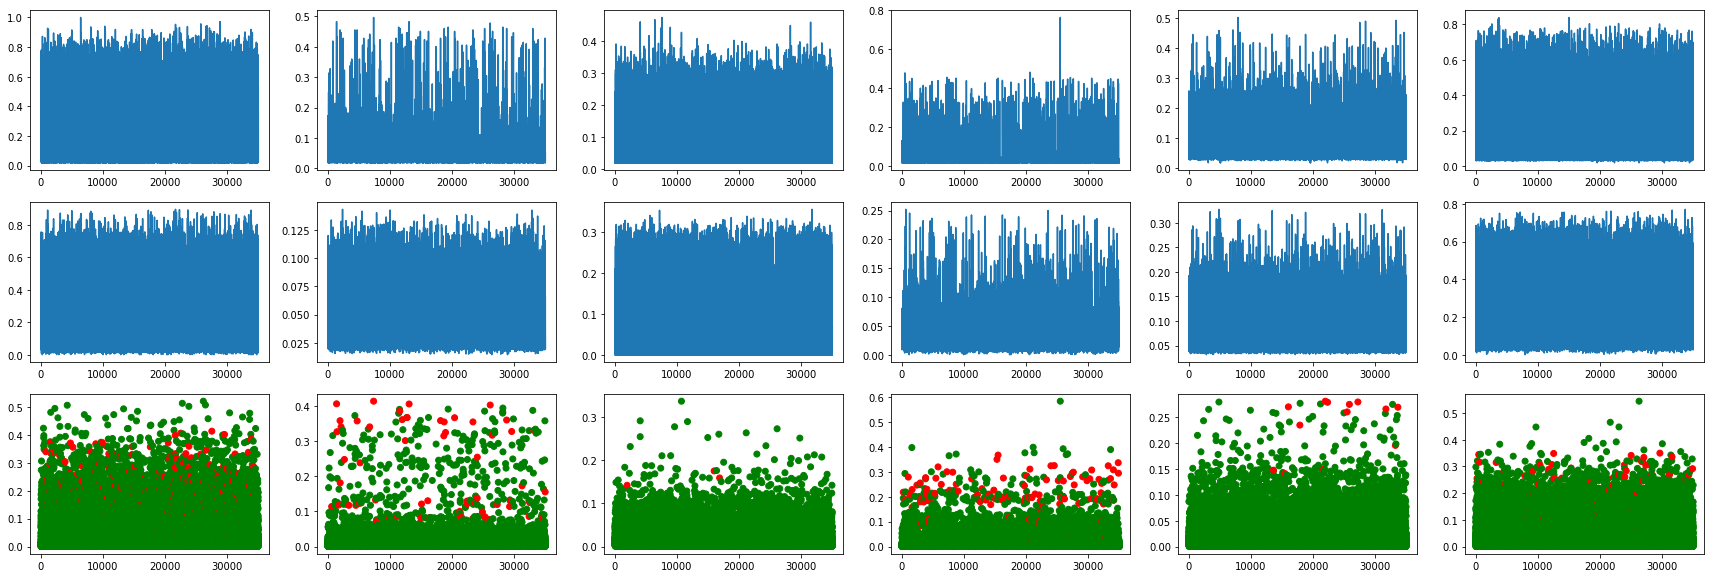

In [23]:
n = len(set(anomalies[:,1]))

plt.figure(figsize=(30, 10))
for i, c in enumerate(set(anomalies[:,1])):
    ax = plt.subplot(3, n, i + 1)
    plt.plot(X[:,0,c])
    ax = plt.subplot(3, n, i + 1 + n)
    plt.plot(X_pred[:,0,c])
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    res = np.abs(X[:,0,c] - X_pred[:,0,c])
    channel_anomalies = anomalies[np.where(anomalies[:,1] == c)]
    colors = np.array(["green"] * X_pred.shape[0])
    colors[channel_anomalies[:,0]] = ["red"]
    plt.scatter(range(len(res)), res, color=colors, cmap='hsv')
    
plt.show()

4
362 2183 2204
362 3022 3042
362 4734 4751
362 6623 6647
362 6812 6847
362 8843 8851
362 10897 10941
362 11044 11084
362 11294 11297
362 12219 12231
362 13008 13026
362 13474 13485
362 14675 14720
362 15008 15064
362 15174 15208
362 19145 19150
362 19862 19885
362 20478 20525
362 21149 21173
362 21323 21331
362 21609 21722
362 21824 21829
362 22507 22541
362 23597 23645
362 23702 23714
362 24207 24264
362 25769 25815
362 28380 28393
362 28553 28566
362 28714 28723
362 30064 30109
362 30187 30191
362 30866 30933
362 32482 32511
362 33510 33527
362 33914 33927
331 1953 1979
331 21274 21312
331 22439 22461
331 23387 23412
331 24076 24093
333 1639 1655
333 2961 2987
333 3169 3212
333 4039 4050
333 8202 8217
333 15483 15516
333 19865 19905
333 20971 20978
333 22240 22343
333 22632 22676
333 31786 31828
333 32119 32146
333 32211 32215
333 34110 34129
153 19749 19781


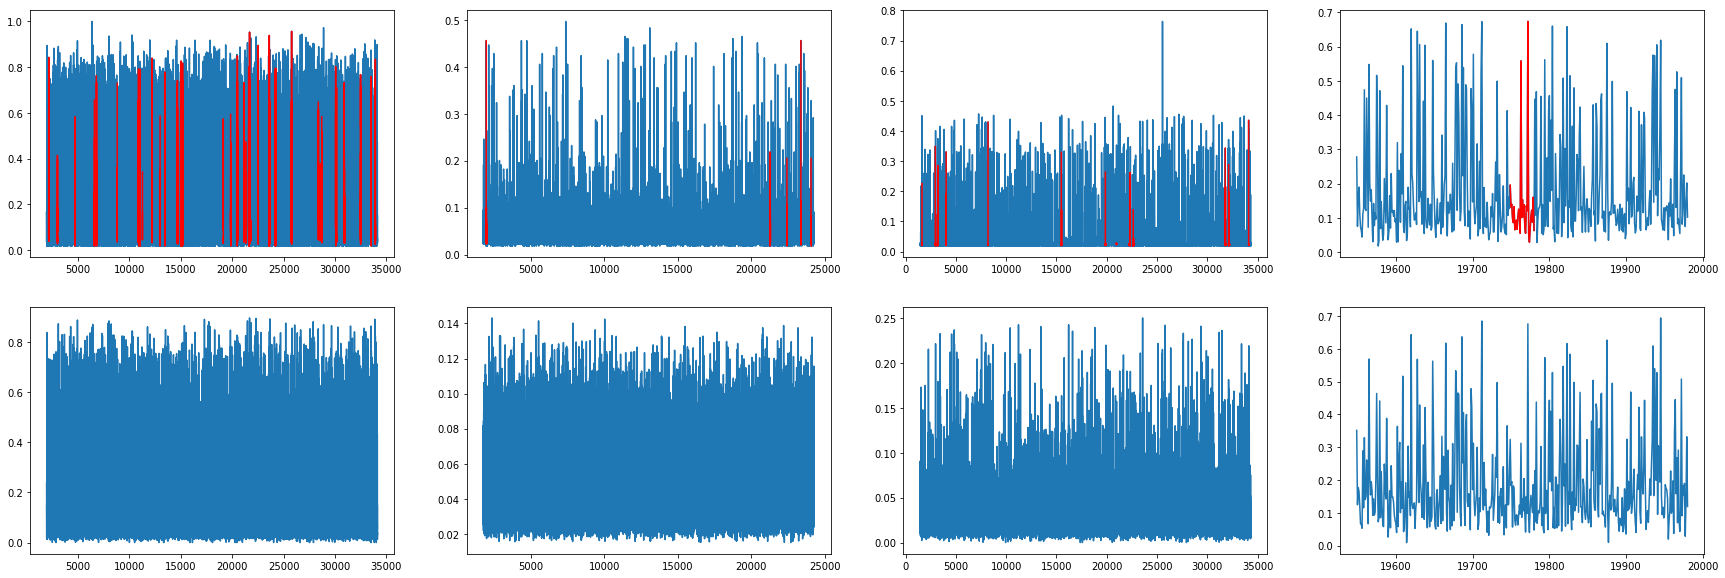

In [25]:
n = min(len(anomaly_intervals), 4)
print(n)
plt.figure(figsize=(30,10))
for i, c in enumerate(anomaly_intervals.keys()):
    if i >= n:
        break
    c = int(c)         
    ax = plt.subplot(2, n, i + 1)
    s = max(0, anomaly_intervals[str(c)][0][0] - 200)
    e = min(anomaly_intervals[str(c)][-1][1] + 200, X.shape[0])
    ax.plot(range(s, e), X[s:e,0,c])
    for start, end in anomaly_intervals[str(c)]:
        print(c, start,end)
        ax.plot(range(start, end), X[start:end,0,c], color="red")
        
    ax = plt.subplot(2, n, i + 1 + n)
    ax.plot(range(s, e), X_pred[s:e,0,c])
        
    
plt.show()

362 2183 2204
362 3022 3042
362 4734 4751
362 6623 6647
362 6812 6847
362 8843 8851
362 10897 10941
362 11044 11084
362 11294 11297
362 12219 12231
362 13008 13026
362 13474 13485
362 14675 14720
362 15008 15064
362 15174 15208
362 19145 19150
362 19862 19885
362 20478 20525
362 21149 21173
362 21323 21331
362 21609 21722
362 21824 21829
362 22507 22541
362 23597 23645
362 23702 23714
362 24207 24264
362 25769 25815
362 28380 28393
362 28553 28566
362 28714 28723
362 30064 30109
362 30187 30191
362 30866 30933
362 32482 32511
362 33510 33527
362 33914 33927


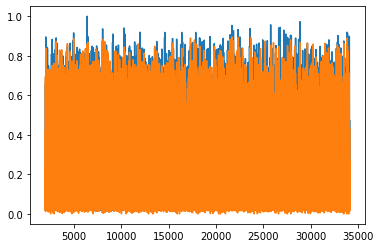

In [33]:
c = str(random.choice(list(anomaly_intervals)))
s = max(0, anomaly_intervals[c][0][0] - 200)
e = min(anomaly_intervals[c][-1][1] + 200, X.shape[0])
plt.plot(range(s, e), X[s:e,0,int(c)])
for start, end in anomaly_intervals[c]:
    print(c, start,end)
    #plt.plot(range(start, end), x_train[start:end,0,int(c)], color="red")
plt.plot(range(s, e), X_pred[s:e,0,int(c)])
plt.show()